# Hands on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from custom_functions import *

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-williambeordo>

In [4]:
!kubectl get pods

NAME                                            READY   STATUS    RESTARTS   AGE
jupyter-williambeordo-b24db280d640a57f-exec-1   1/1     Running   0          9s
jupyter-williambeordo-b24db280d640a57f-exec-2   1/1     Running   0          8s
jupyter-williambeordo-b24db280d640a57f-exec-3   1/1     Running   0          8s
jupyter-williambeordo-b24db280d640a57f-exec-4   1/1     Running   0          8s
jupyter-williambeordo-b24db280d640a57f-exec-5   1/1     Running   0          8s


## Prepare the input data

In [5]:
inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet' 

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 5.94 ms, sys: 2.91 ms, total: 8.84 ms
Wall time: 4.87 s


In [6]:
total_events = df.count()

print('There are '+str(total_events)+' events')

There are 979519 events


#### QUESTION 1: is the dataset unbalanced? Do we need undersampling?

In [7]:
df.groupby('label').count().orderBy('count').show()
# In the dataset the number of signal and background events differ of only 6%, 
# therefore both classes are well represented and we can basically consider the dataset balanced. 

+-----+------+
|label| count|
+-----+------+
|  0.0|460646|
|  1.0|518873|
+-----+------+



#### QUESTION 2: Split the dataset into 5 parts with random events

In [8]:
df1, df2, df3, df4, df5 = df.randomSplit([0.2,0.2,0.2,0.2,0.2])
print(df1.count(),df2.count(),df3.count(),df4.count(),df5.count())

196129 195896 195947 195968 195579


#### QUESTION 3: split the dataset for training and test

In [9]:
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 783450
Events for validation 196069


#### Create the input feature vector

Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [10]:
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature, outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

## ML with pyspark

Try to solve the signal vs background classification problem using a new algorithm of your choice (obviously, not GBT or MCP)
Documentation at: https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

In [11]:
from pyspark.ml.classification import RandomForestClassifier

Let's fit the model on the **training dataset**:

In [12]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=30, maxDepth=5)

In [13]:
%%time
rf_model = rf.fit(train)

CPU times: user 21.6 ms, sys: 7.35 ms, total: 29 ms
Wall time: 11.9 s


#### QUESTION 4: Compute the accuracy on the test dataset

Test set AUC = 0.7418695628340594


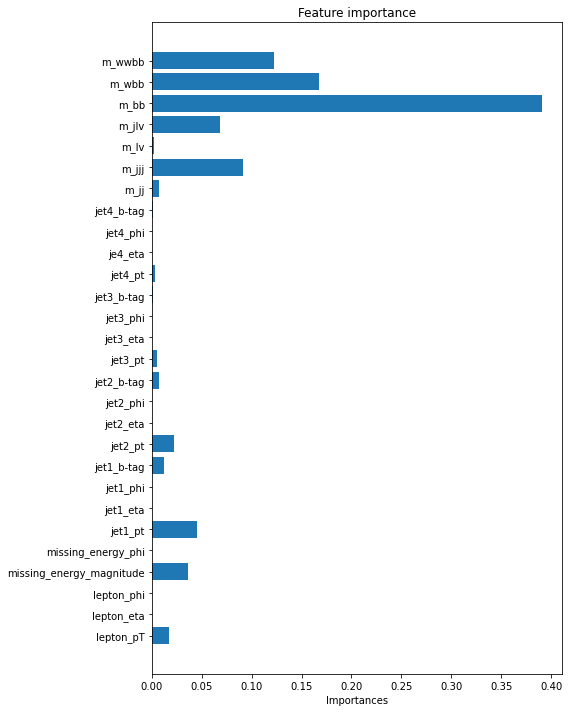

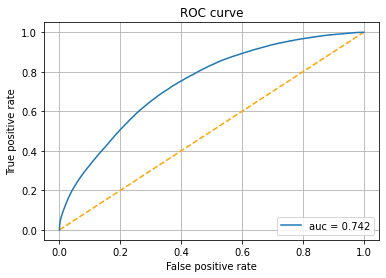

AUC: 0.742
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|79433|
|  0.0|       1.0|39884|
|  1.0|       0.0|24761|
|  0.0|       0.0|51991|
+-----+----------+-----+

n precision: 0.666
n recall: 0.762
n accuracy: 0.670
n F1 score: 0.711


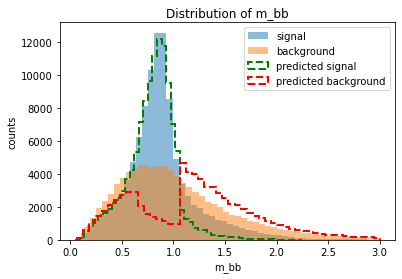

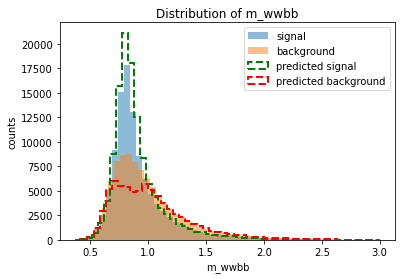

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = rf_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

drawFeatures(feature, rf_model)
drawROC(result)
printMetrics(evaluator, result)
plotSignalvsBgWithPrediction(test, result, 'm_bb')
plotSignalvsBgWithPrediction(test, result, 'm_wwbb')

#### QUESTION 5: Are we over/under-fitting the data? How could the accuracy be improved?

The model seems to underfit the data, since there is a clear underestimation of the background in the peak of the invariant mass. In order to improve the accuracy we could perform an hyperparameter scan, looking for the best value of numTrees and maxDepth, or perform a feature selection. In fact, from the feature importance plot it's clear that our model has trained using very few features (with m_wwbb, m_wbb, m_bb and m_jjj contributing for more than 70%). Thus, the model should be simplified by cutting off irrelevant features like those related to the jets.

#### Hyperparameter tuning

We use the *spark_sklearn.grid_search* method.

In [15]:
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

paramGrid = ParamGridBuilder()\
  .addGrid(rf.numTrees, [10,80])\
  .addGrid(rf.maxDepth, [3,10])\
  .build()

We will use 77866  events for the grid search.


#### QUESTION 6: Compare n k-cross validator vs TrainValidation split methods 

In [16]:
# The two methods give very similar results, even if the TrainValidationSlit method is three time faster.

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=5, parallelism=num_workers)

In [17]:
%time bestModel_cv = cv.fit(subSample)

CPU times: user 1.13 s, sys: 560 ms, total: 1.69 s
Wall time: 2min 17s


In [18]:
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8) # 80% of the data will be used for training, 20% for validation

In [19]:
%time bestModel_tvs = tvs.fit(subSample)

CPU times: user 203 ms, sys: 76.6 ms, total: 280 ms
Wall time: 42.8 s


In [20]:
print('numTrees = '+str(bestModel_cv.bestModel._java_obj.getNumTrees()))
print('maxDepth = '+str(bestModel_cv.bestModel._java_obj.getMaxDepth()))
print('numTrees = '+str(bestModel_tvs.bestModel._java_obj.getNumTrees()))
print('maxDepth = '+str(bestModel_tvs.bestModel._java_obj.getMaxDepth()))

numTrees = 80
maxDepth = 10
numTrees = 80
maxDepth = 10


In [21]:
result_cv = bestModel_cv.transform(test)
result_tvs = bestModel_tvs.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result_cv)))
print("Test set AUC = " + str(evaluator.evaluate(result_tvs)))

Test set AUC = 0.7838032817119399
Test set AUC = 0.7838032801972354


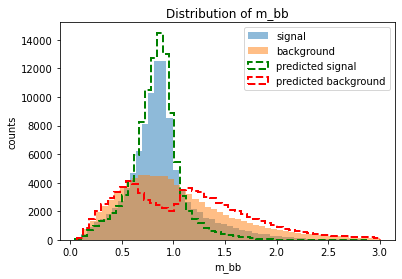

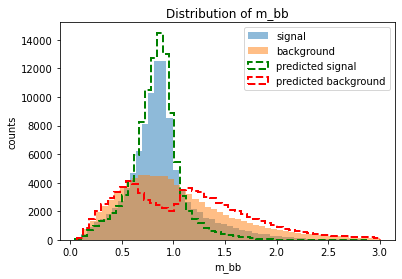

In [22]:
plotSignalvsBgWithPrediction(test, result_cv, 'm_bb')
plotSignalvsBgWithPrediction(test, result_tvs, 'm_bb')

#### QUESTION 7: do you get a better accuracy? Why? Are you over/underfitting?

We got a better accuracy (increased by a 6%), because the RandomForest model is probably too simple with numTrees=30 and MaxDepth=5.
The hyperparameter tuning yielded numTrees=80 and numDepth=10 for the best combination of hyperparameters, which are the boundaries of the explored hyperparameter space: therefore, further training and tuning may be necessary.
However, the signal-vs-background plot still exhibits the cut of the background in the peak of the invariant mass, meaning that there is still an underfitting problem, albeit minor, or that the model is not the best one to perform this task.

#### QUESTION 8

pick any two models (can be any from pyspark MLLib, Keras Sequential, BigDL sequential) and:
- compare them in terms of performances (you can use results from previous days)
- compare how they scale in terms of performances and training time when you change the number of executors (for example, from 1 to 5)
- discuss the results

The Grandient Boosting Trees and the Random Forest produce very similar results, both in term of accuracy and prediction on the test set. On the other hand, the Keras sequential model seems to be better suited to perform this kind of task with respect to the other two algorithms, since the accuracy is higher (0.82 instead of 0.78) and the test dataset is more closely reproduced: from the signal-vs-background plot, we can see that the background is not sharply cut off in the invariant mass peak, contrary to what happens with the other two models.

The number of executors only affects The Grandient Boosting Trees and the Random Forest models, since Keras is not distributed with spark. Signal-vs-Backgroung plots and accuracy values remain substantially unchanged as the number of executors increases, while the training time decreases significantly, as shown at the bottom for the dataset of 10 millions of events.

In [23]:
# ML model: GBT (Gradient Boosting Trees)

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=20, maxDepth=5) 

In [24]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 18.4 ms, sys: 7.82 ms, total: 26.3 ms
Wall time: 25.5 s


Test set AUC = 0.7821805183136271


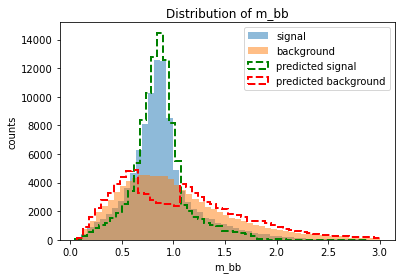

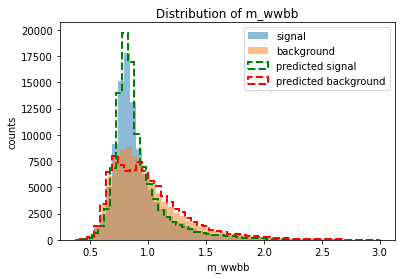

In [25]:
result = gbt_model.transform(test)
print("Test set AUC = " + str(evaluator.evaluate(result)))
plotSignalvsBgWithPrediction(test, result, 'm_bb')
plotSignalvsBgWithPrediction(test, result, 'm_wwbb')

In [26]:
# Neural Network: Keras sequential model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(1337)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(28,)))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

X, y, X_test, y_test = prepareData(df, 0.2)
print('Events for training '+str(len(y)))
print('Events for validation '+str(len(y_test)))

Events for training 783915
Events for validation 195604


In [27]:
%%time
history = model.fit(X, y, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
6125/6125 [==============================] - 21s 3ms/step - loss: 0.6023 - accuracy: 0.6698 - val_loss: 0.5766 - val_accuracy: 0.6955
Epoch 2/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5650 - accuracy: 0.7044 - val_loss: 0.5566 - val_accuracy: 0.7108
Epoch 3/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5493 - accuracy: 0.7169 - val_loss: 0.5434 - val_accuracy: 0.7209
Epoch 4/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5388 - accuracy: 0.7249 - val_loss: 0.5347 - val_accuracy: 0.7264
Epoch 5/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5309 - accuracy: 0.7310 - val_loss: 0.5326 - val_accuracy: 0.7302
Epoch 6/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5254 - accuracy: 0.7347 - val_loss: 0.5269 - val_accuracy: 0.7319
Epoch 7/10
6125/6125 [==============================] - 20s 3ms/step - loss: 0.5209 - accuracy: 0.7384 - val_loss: 0.5264 - val_ac

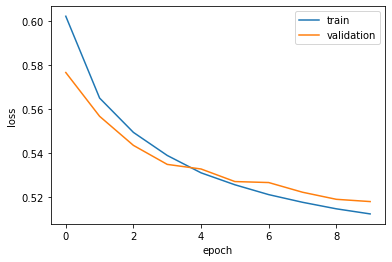

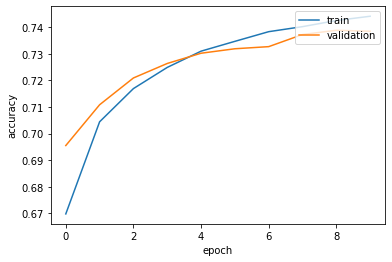

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2900      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,101
Trainable params: 13,101
Non-trainable params: 0
_________________________________________________________________


In [28]:
plotVsEpoch(history, 'loss')
plotVsEpoch(history, 'accuracy')
model.summary()

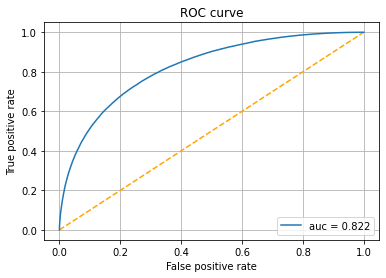

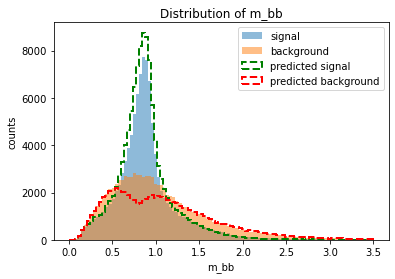

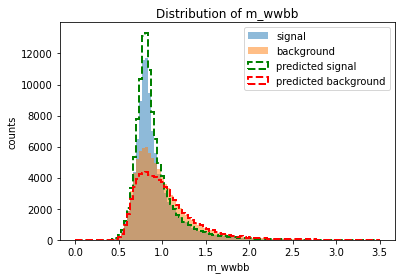

In [29]:
y_pred = model.predict(X_test)
drawROC2(y_test, y_pred)
plotSignalvsBgWithPrediction2(X_test[:,25], y_test, y_pred, 'm_bb')
plotSignalvsBgWithPrediction2(X_test[:,27], y_test, y_pred, 'm_wwbb')

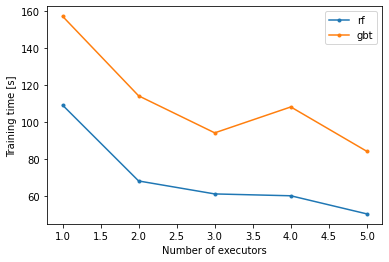

In [30]:
#Scaling test for GBT and RF models with 10M events

rf10 = [109, 68, 61, 60, 50.2]
gbt10 = [157, 114, 94, 108, 84]
ex = [1,2,3,4,5]
plt.plot(ex, rf10, '.-', label='rf')
plt.plot(ex, gbt10, '.-', label='gbt')
plt.xlabel('Number of executors')
plt.ylabel('Training time [s]')
plt.legend()
plt.show()

In [31]:
spark.stop()